In [1]:
#import libraries
import numpy as np
import pandas as pd
import yfinance as yf
from pytickersymbols import PyTickerSymbols
import cvxpy as cp
import matplotlib.pyplot as plt
import jax

In [2]:
#retrieve symbols
stock_data = PyTickerSymbols()
nasdaq_tickers = stock_data.get_stocks_by_index('NASDAQ 100')
symbols = [i['symbol'] for i in nasdaq_tickers]

In [3]:
#function to retrieve data for the symbols. Close price is retrieved
def data_pull(start_date, end_date):
    #date format: YYYY-MM-DD
    return yf.download(symbols, start=start_date, end=end_date)

In [4]:
#First time period
data = data_pull('2018-12-30','2024-01-01')['Close']
monthly_close = data.resample('ME').last()

[*********************100%***********************]  101 of 101 completed

3 Failed downloads:
['SPLK', 'SGEN', 'ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [5]:
na_columns = monthly_close.columns[monthly_close.isna().any()].tolist()
na_columns

['ABNB', 'ATVI', 'CRWD', 'DDOG', 'FISV', 'LCID', 'SGEN', 'SPLK', 'ZM']

In [6]:
#Second time period
data2 = data_pull('2013-12-30','2019-01-01')['Close']
monthly_close2 = data2.resample('ME').last()

[*********************100%***********************]  101 of 101 completed

9 Failed downloads:
['SPLK', 'SGEN', 'ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['DDOG', 'ZM', 'ABNB', 'FISV', 'LCID', 'CRWD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-12-30 -> 2019-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1388379600, endDate = 1546318800")')


In [7]:
na_columns2 = monthly_close2.columns[monthly_close2.isna().any()].tolist()
na_columns2

['ABNB',
 'ATVI',
 'CRWD',
 'DDOG',
 'DOCU',
 'FISV',
 'JD',
 'KHC',
 'LCID',
 'MRNA',
 'OKTA',
 'PDD',
 'PYPL',
 'SGEN',
 'SPLK',
 'TEAM',
 'ZM',
 'ZS']

In [8]:
#Third time period
data3 = data_pull('2008-12-30','2014-01-01')['Close']
monthly_close3 = data3.resample('ME').last()

[*********************100%***********************]  101 of 101 completed

18 Failed downloads:
['SPLK', 'SGEN', 'ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['DOCU', 'OKTA', 'PDD', 'MRNA', 'JD', 'ZS', 'DDOG', 'ZM', 'ABNB', 'LCID', 'TEAM', 'FISV', 'CRWD', 'PYPL', 'KHC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2008-12-30 -> 2014-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1230613200, endDate = 1388552400")')


In [9]:
na_columns3 = monthly_close3.columns[monthly_close3.isna().any()].tolist()
na_columns3

['ABNB',
 'ATVI',
 'AVGO',
 'CHTR',
 'CRWD',
 'DDOG',
 'DOCU',
 'FISV',
 'FTNT',
 'JD',
 'KHC',
 'LCID',
 'META',
 'MRNA',
 'NXPI',
 'OKTA',
 'PANW',
 'PDD',
 'PYPL',
 'SGEN',
 'SPLK',
 'TEAM',
 'TSLA',
 'VRSK',
 'WDAY',
 'ZM',
 'ZS']

In [10]:
#remove these because the data is unavailable
for j in ['SPLK', 'ATVI', 'SGEN']:
    if j in symbols:
        symbols.remove(j)

#remove because there are NA values
for j in na_columns:
    if j in symbols:
        symbols.remove(j)

for j in na_columns2:
    if j in symbols:
        symbols.remove(j)

for j in na_columns3:
    if j in symbols:
        symbols.remove(j)

In [11]:
#retrieve data again but with the NA stocks removed this time
data = data_pull('2018-12-30','2024-01-01')['Close']
monthly_close = data.resample('ME').last()

data2 = data_pull('2013-12-30','2019-01-01')['Close']
monthly_close2 = data2.resample('ME').last()

data3 = data_pull('2008-12-30','2014-01-01')['Close']
monthly_close3 = data3.resample('ME').last()

[*********************100%***********************]  74 of 74 completed
[*********************100%***********************]  74 of 74 completed
[*********************100%***********************]  74 of 74 completed


In [12]:
#use time period 1 for the main analysis
#First, we do everything without the CAPM and its covariance

#Calculating monthly returns
monthly_returns = monthly_close.pct_change().iloc[1:]

#Expected monthly return
expected_returns = monthly_returns.mean()

#Volatility
volatility = monthly_returns.std().to_numpy()

#Covariance Matrix
covariance_mat = monthly_returns.cov().to_numpy()

In [13]:
covariance_mat.shape

(74, 74)

In [14]:
#Using the Ledoit-Wolf Shrinkage
from sklearn.covariance import LedoitWolf

ld_covariance_mat = LedoitWolf().fit(monthly_returns).covariance_

In [15]:
#Example: Let's see the return of equal weight portfolio
#empirical covariance
x = np.array([1/74 for i in range(74)])
port_return = expected_returns @ x
port_variance = x.T @ covariance_mat @ x
port_return, port_variance

(0.017436777644941094, 0.003353680063339898)

In [16]:
#Example: Let's see the return of equal weight portfolio
#ledoit-wolf covariance
x = np.array([1/74 for i in range(74)])
port_return = expected_returns @ x
port_variance = x.T @ ld_covariance_mat @ x
port_return, port_variance

(0.017436777644941094, 0.0029690313551677216)

In [17]:
#Optimization using CVXPY
#empirical covariance
x = cp.Variable(74)
port_variance = cp.quad_form(x, covariance_mat)
port_return = cp.matmul(expected_returns, x)

#Objective 1: Find Minimum Variance Portfolio
objective = cp.Minimize(port_variance)
constraints = [x >= 0, x <= 1,cp.sum(x) == 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#some weights are less than 0 but effectively 0 since they are extremely small negative values
#check using x.value < -1e-19
#x.value show the weights
port_return.value, port_variance.value

(0.008984452822254735, 0.0010042648561005459)

In [18]:
#Optimization using CVXPY
#ledoit-wolf
x = cp.Variable(74)
port_variance = cp.quad_form(x, ld_covariance_mat)
port_return = cp.matmul(expected_returns, x)

#Objective 1: Find Minimum Variance Portfolio
objective = cp.Minimize(port_variance)
constraints = [x >= 0, x <= 1,cp.sum(x) == 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#some weights are less than 0 but effectively 0 since they are extremely small negative values
#check using x.value < -1e-19
#x.value show the weights
port_return.value, port_variance.value

(0.009498135996708268, 0.000997047104320402)

In [19]:
#Objective 2: Maximise return for a given variance
#empirical covariance
x = cp.Variable(74)
port_return = cp.matmul(expected_returns, x)
port_variance = cp.quad_form(x, covariance_mat)

objective = cp.Maximize(port_return)
constraints = [x >= 0, x <= 1,cp.sum(x) == 1, port_variance <= 0.0036]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#x.value show the weights
port_return.value, port_variance.value

(0.03092546009807136, 0.0035999999901592476)

In [20]:
#Objective 2: Maximise return for a given variance
#ledoit-wolf covariance
x = cp.Variable(74)
port_return = cp.matmul(expected_returns, x)
port_variance = cp.quad_form(x, ld_covariance_mat)

objective = cp.Maximize(port_return)
constraints = [x >= 0, x <= 1,cp.sum(x) == 1, port_variance <= 0.0036]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#x.value show the weights
port_return.value, port_variance.value

(0.03209584335028351, 0.0035999999987148795)

In [21]:
#Objective 3: Minimise variance for a given return
#empirical covariance
x = cp.Variable(74)
port_return = cp.matmul(expected_returns, x)
port_variance = cp.quad_form(x, covariance_mat)

objective = cp.Minimize(port_variance)
constraints = [x >= 0, x <= 1,cp.sum(x) == 1, port_return >= 0.035]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#x.value show the weights
port_return.value, port_variance.value

(0.035, 0.004901173286873908)

In [22]:
#Objective 3: Minimise variance for a given return
#ledoit-wolf covariance
x = cp.Variable(74)
port_return = cp.matmul(expected_returns, x)
port_variance = cp.quad_form(x, ld_covariance_mat)

objective = cp.Minimize(port_variance)
constraints = [x >= 0, x <= 1,cp.sum(x) == 1, port_return >= 0.035]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#x.value show the weights
port_return.value, port_variance.value

(0.035, 0.004473786883289393)

In [23]:
#Plotting the efficient frontier

#First, we create a function that provides the maximum return for a given risk
def return_maximizer(risk, covariance_mat):
    x = cp.Variable(74)
    port_return = cp.matmul(expected_returns, x)
    port_variance = cp.quad_form(x, covariance_mat)

    objective = cp.Maximize(port_return)
    constraints = [x >= 0, x <= 1,cp.sum(x) == 1, port_variance <= risk]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return port_return.value

#vectorize function but only vectorize risk, covariance is not vectorized
return_maximizer = np.vectorize(return_maximizer)
return_maximizer.excluded.add(1)

Text(0.5, 1.0, 'Efficient Frontier')

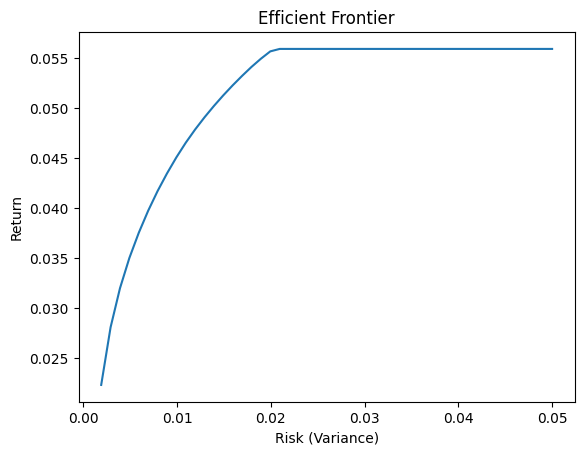

In [24]:
#Now we generate the maximum returns for multiple values of risk for plotting
#empirical covariance
risk_vals = np.linspace(0.0009,0.05,50)
max_returns = return_maximizer(risk_vals, covariance_mat)
plt.plot(risk_vals, max_returns)
plt.xlabel('Risk (Variance)')
plt.ylabel('Return')
plt.title('Efficient Frontier')

Text(0.5, 1.0, 'Efficient Frontier (Ledoit-Wolf)')

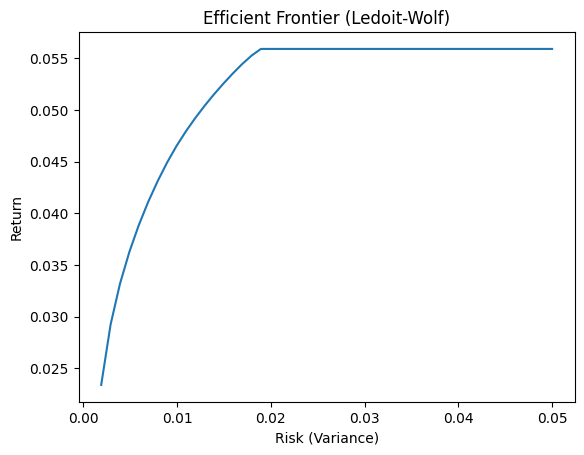

In [25]:
#Now we generate the maximum returns for multiple values of risk for plotting
risk_vals = np.linspace(0.0009,0.05,50)
max_returns = return_maximizer(risk_vals, ld_covariance_mat)
plt.plot(risk_vals, max_returns)
plt.xlabel('Risk (Variance)')
plt.ylabel('Return')
plt.title('Efficient Frontier (Ledoit-Wolf)')

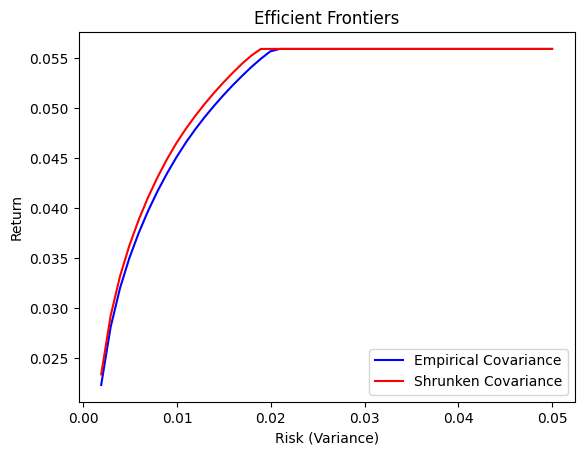

In [26]:
#Both curves together
risk_vals = np.linspace(0.0009,0.05,50)
max_returns = return_maximizer(risk_vals, covariance_mat)
ld_max_returns = return_maximizer(risk_vals, ld_covariance_mat)

plt.plot(risk_vals, max_returns, label='Empirical Covariance', color='blue')

# Plot the second curve on the same axis
plt.plot(risk_vals, ld_max_returns, label='Shrunken Covariance', color='red')

# Add labels and a legend
plt.xlabel('Risk (Variance)')
plt.ylabel('Return')
plt.title('Efficient Frontiers')
plt.legend()

# Show the plot
plt.show()

In [28]:
#Using the next few cells, we calculate the minimum variance portfolio across all 3 time
#periods, for both empirical and shrunken covariance. Then we compare the results

#empirical covariance
#Optimization using CVXPY
#empirical covariance
x = cp.Variable(74)
port_variance = cp.quad_form(x, covariance_mat)
port_return = cp.matmul(expected_returns, x)

#Objective 1: Find Minimum Variance Portfolio
objective = cp.Minimize(port_variance)
constraints = [x >= 0, x <= 1,cp.sum(x) == 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#some weights are less than 0 but effectively 0 since they are extremely small negative values
#check using x.value < -1e-19
#x.value show the weights
port_return.value, port_variance.value

(0.008984452822254735, 0.0010042648561005459)

In [29]:
#Optimization using CVXPY
#ledoit-wolf shrunked covariance
ld_x = cp.Variable(74)
port_variance = cp.quad_form(ld_x, ld_covariance_mat)
port_return = cp.matmul(expected_returns, ld_x)

#Objective 1: Find Minimum Variance Portfolio
objective = cp.Minimize(port_variance)
constraints = [ld_x >= 0, ld_x <= 1,cp.sum(ld_x) == 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#some weights are less than 0 but effectively 0 since they are extremely small negative values
#check using x.value < -1e-19
#x.value show the weights
port_return.value, port_variance.value

(0.009498135996708268, 0.000997047104320402)

In [30]:
#Minimum variance portfolio for time period 2:
#Calculating monthly returns
monthly_returns2 = monthly_close2.pct_change().iloc[1:]

#Expected monthly return
expected_returns2 = monthly_returns2.mean()

#Volatility
volatility2 = monthly_returns2.std().to_numpy()

#Covariance Matrix
covariance_mat2 = monthly_returns2.cov().to_numpy()
ld_covariance_mat2 = LedoitWolf().fit(monthly_returns2).covariance_

#Minimize variance
#Optimization using CVXPY
x2 = cp.Variable(74)
port_variance2 = cp.quad_form(x2, covariance_mat2)
port_return2 = cp.matmul(expected_returns2, x2)

#Find Minimum Variance Portfolio
objective = cp.Minimize(port_variance2)
constraints = [x2 >= 0, x2 <= 1,cp.sum(x2) == 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#some values are less than 0 but effectively 0 since they are extremely small negative values
#check using x.value < -1e-19
port_return2.value, port_variance2.value

(0.01008517423461401, 0.0005129764379527024)

In [31]:
#Now using the Ledoit-Wolf shrunk covariance
#Minimize variance
#Optimization using CVXPY
ld_x2 = cp.Variable(74)
port_variance2 = cp.quad_form(ld_x2, ld_covariance_mat2)
port_return2 = cp.matmul(expected_returns2, ld_x2)

#Find Minimum Variance Portfolio
objective = cp.Minimize(port_variance2)
constraints = [ld_x2 >= 0, ld_x2 <= 1,cp.sum(ld_x2) == 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#some values are less than 0 but effectively 0 since they are extremely small negative values
#check using x.value < -1e-19
port_return2.value, port_variance2.value

(0.010169510356593572, 0.00046660473990411846)

In [32]:
#Minimum variance portfolio for time period 3:
#Calculating monthly returns
monthly_returns3 = monthly_close3.pct_change().iloc[1:]

#Expected monthly return
expected_returns3 = monthly_returns3.mean()

#Volatility
volatility3 = monthly_returns3.std().to_numpy()

#Covariance Matrix
covariance_mat3 = monthly_returns3.cov().to_numpy()
ld_covariance_mat3 = LedoitWolf().fit(monthly_returns3).covariance_

#Minimize variance
#Optimization using CVXPY
x3 = cp.Variable(74)
port_variance3 = cp.quad_form(x3, covariance_mat3)
port_return3 = cp.matmul(expected_returns3, x3)

#Find Minimum Variance Portfolio
objective = cp.Minimize(port_variance3)
constraints = [x3 >= 0, x3 <= 1,cp.sum(x3) == 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#some values are less than 0 but effectively 0 since they are extremely small negative values
#check using x.value < -1e-19
port_return3.value, port_variance3.value

(0.017317667296336443, 0.0005401507734417399)

In [33]:
#Now using Ledoit-Wolf shrunk covariance
#Minimize variance
#Optimization using CVXPY
ld_x3 = cp.Variable(74)
port_variance3 = cp.quad_form(ld_x3, ld_covariance_mat3)
port_return3 = cp.matmul(expected_returns3, ld_x3)

#Find Minimum Variance Portfolio
objective = cp.Minimize(port_variance3)
constraints = [ld_x3 >= 0, ld_x3 <= 1,cp.sum(ld_x3) == 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#some values are less than 0 but effectively 0 since they are extremely small negative values
#check using x.value < -1e-19
port_return3.value, port_variance3.value

(0.018898703821089827, 0.0005686903985752443)

In [34]:
#Time period 1 vs 2 (empirical covariance portfolio stability)
cp.norm(x-x2).value / np.sqrt(2)

0.28717646266244556

In [35]:
#Time period 1 vs 2 (shrunken covariance portfolio stability)
cp.norm(ld_x-ld_x2).value / np.sqrt(2)

0.19045604435830035

In [36]:
#Time period 2 vs 3 (empirical covariance portfolio stability)
cp.norm(x2-x3).value / np.sqrt(2)

0.28132519697847946

In [37]:
#Time period 2 vs 3 (shrunken covariance portfolio stability)
cp.norm(ld_x2-ld_x3).value / np.sqrt(2)

0.1638430580480359

In [38]:
#Time period 1 vs 3 (empirical covariance portfolio stability)
cp.norm(x-x3).value / np.sqrt(2)

0.22798584439924377

In [39]:
#Time period 1 vs 3 (shrunken covariance portfolio stability)
cp.norm(ld_x-ld_x3).value / np.sqrt(2)

0.2012451496430769